In [1]:
import numpy as np
import pandas as pd
from typing import Optional, Dict, Callable, Tuple

In [2]:
from src.cls.backtest import Backtester

## Data

In [3]:
df = pd.read_csv("../data/gold_prices.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [4]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,428.700012,431.000000,431.000000,431.000000,4
2005-01-04,428.500000,428.500000,428.500000,428.500000,108
2005-01-05,426.600006,425.700012,425.700012,425.700012,2
2005-01-06,421.000000,421.000000,421.000000,421.000000,1
2005-01-07,418.899994,423.700012,418.700012,423.700012,1
...,...,...,...,...,...
2025-09-24,3732.100098,3772.500000,3732.100098,3769.800049,588
2025-09-25,3736.899902,3756.000000,3724.699951,3742.800049,1899
2025-09-26,3775.300049,3775.300049,3775.300049,3775.300049,19308


## Trigger Function

In [5]:
def prepare_technical_columns(
    df: pd.DataFrame,
    *,
    ema_fast_span_d: int = 12,
    ema_slow_span_d: int = 26,
    ema_fast_span_w: int = 12,
    ema_slow_span_w: int = 26,
    sma_w_window: int = 100,
    weekly_rule: str = 'W-FRI'
) -> pd.DataFrame:
    """
    Compute technical indicator columns needed by the example trigger, similar to the
    original in-class defaults. Mutates the DataFrame in-place and returns it.

    Adds columns:
      - ema12_d, ema26_d, macd_d (daily)
      - ema12_w_prev, ema26_w_prev, ema12_w, ema26_w, macd_w, sma100_w (weekly mapped to daily)
    """
    df = df.copy()

    # Daily EMAs for MACD(ema_fast_span_d, ema_slow_span_d)
    df['ema12_d'] = df['Close'].ewm(span=ema_fast_span_d, adjust=False).mean()
    df['ema26_d'] = df['Close'].ewm(span=ema_slow_span_d, adjust=False).mean()
    df['macd_d'] = df['ema12_d'] - df['ema26_d']

    # Weekly resample (Close at week end) and EMAs for MACD(ema_fast_span_w, ema_slow_span_w)
    weekly = df['Close'].resample(weekly_rule).last().to_frame('CloseW')
    weekly['ema12_w'] = weekly['CloseW'].ewm(span=ema_fast_span_w, adjust=False).mean()
    weekly['ema26_w'] = weekly['CloseW'].ewm(span=ema_slow_span_w, adjust=False).mean()
    weekly['macd_w'] = weekly['ema12_w'] - weekly['ema26_w']
    weekly['sma100_w'] = weekly['CloseW'].rolling(window=sma_w_window, min_periods=1).mean()

    # Previous week's EMAs
    weekly['ema12_w_prev'] = weekly['ema12_w'].shift(1)
    weekly['ema26_w_prev'] = weekly['ema26_w'].shift(1)

    # Map weekly features to daily dates (forward-fill within the week)
    mapped = weekly[['ema12_w_prev', 'ema26_w_prev', 'ema12_w', 'ema26_w', 'macd_w', 'sma100_w']].reindex(df.index, method='ffill')
    df['ema12_w_prev'] = mapped['ema12_w_prev']
    df['ema26_w_prev'] = mapped['ema26_w_prev']
    df['ema12_w'] = mapped['ema12_w']
    df['ema26_w'] = mapped['ema26_w']
    df['macd_w'] = mapped['macd_w']
    df['sma100_w'] = mapped['sma100_w']

    return df


def make_technical_buy_fn(drop_trigger_pct: Optional[float] = 0.02) -> Callable[[pd.DataFrame, int], Tuple[bool, Optional[float]]]:
    """
    Factory returning a trigger function reproducing the previous default behavior, with an
    integrated optional daily drop filter parameter.

    Conditions (same as before):
      - last week: EMA12(w_prev) < EMA26(w_prev)
      - this week: EMA12(w) > EMA26(w)  (weekly MACD 12>26)
      - today:     MACD(d) < 0
      - this week: MACD(w) > 0
      - today:     Close > SMA100(w)
      - and optional: Close[t] <= Close[t-1] * (1 - drop_trigger_pct) if provided
    """

    def buy_fn(df: pd.DataFrame, i: int, **kwargs) -> Tuple[bool, Optional[float]]:
        # Optional daily drop filter
        if drop_trigger_pct is not None:
            if i <= 0:
                return False, None
            c_today = df['Close'].iloc[i]
            c_prev = df['Close'].iloc[i - 1]
            ok_drop = (
                np.isfinite(c_today)
                and np.isfinite(c_prev)
                and (c_today <= c_prev * (1.0 - float(drop_trigger_pct)))
            )
            if not ok_drop:
                return False, None

        row = df.iloc[i]

        cond_last_week = (
            np.isfinite(row.get('ema12_w_prev', np.nan)) and
            np.isfinite(row.get('ema26_w_prev', np.nan)) and
            (row['ema12_w_prev'] < row['ema26_w_prev'])
        )
        cond_today_cross = (
            np.isfinite(row.get('ema12_w', np.nan)) and
            np.isfinite(row.get('ema26_w', np.nan)) and
            (row['ema12_w'] > row['ema26_w'])
        )
        cond_macd_d = (
            np.isfinite(row.get('macd_d', np.nan)) and
            (row['macd_d'] < 0)
        )
        cond_macd_w = (
            np.isfinite(row.get('macd_w', np.nan)) and
            (row['macd_w'] > 0)
        )
        cond_sma_w = (
            np.isfinite(row.get('sma100_w', np.nan)) and
            np.isfinite(row.get('Close', np.nan)) and
            (row['Close'] > row['sma100_w'])
        )

        should = bool(cond_last_week and cond_today_cross and cond_macd_d and cond_macd_w and cond_sma_w)
        return should, None

    return buy_fn


# Backward-compatible alias
def make_technical_trigger(drop_trigger_pct: Optional[float] = 0.02) -> Callable[[pd.DataFrame, int], Tuple[bool, Optional[float]]]:
    """
    Alias for make_technical_buy_fn to preserve backward compatibility.
    """
    return make_technical_buy_fn(drop_trigger_pct)


def make_threshold_sell_fn(
    rise_threshold_pct: float = 0.01,
    sell_pct_of_position: float = 0.10,
) -> Callable[[pd.DataFrame, int], Tuple[bool, Optional[float], Dict]]:
    """
    Create a simple sell function that triggers when today's Close rises by the
    specified threshold over yesterday's Close, and sells a fixed percentage of
    the current position (default: 10%).

    Returns (should_sell, None, action_dict) where action_dict indicates a
    percent-based reduction. Execution price defaults to Close (engine-side).
    """
    thr = float(rise_threshold_pct)
    pct = float(sell_pct_of_position)

    def sell_fn(df: pd.DataFrame, i: int, **kwargs) -> Tuple[bool, Optional[float], Dict]:
        if i <= 0:
            return False, None, {}
        c_today = df['Close'].iloc[i]
        c_prev = df['Close'].iloc[i - 1]
        if not (np.isfinite(c_today) and np.isfinite(c_prev)):
            return False, None, {}
        should = c_today >= c_prev * (1.0 + thr)
        if not should:
            return False, None, {}
        return True, None, {'type': 'percent', 'pct': pct}

    return sell_fn

## Backtesting

### Run

In [6]:
buy_fn = make_technical_buy_fn(drop_trigger_pct=0.02)
sell_fn = make_threshold_sell_fn(rise_threshold_pct=0.05, sell_pct_of_position=0.10)

In [7]:
bt = Backtester(
    data=df,
    start_fund=10_000,
    target_leverage=10.0,
    fee_pct=0.0002,
    mmr=0.005,
    buy_on_start=True,
    print_daily=False,
    buy_at="trigger",
    buy_fn=buy_fn,
    sell_fn=sell_fn,
    precompute_fn=prepare_technical_columns,
    start_date="2020-01-01",
    end_date=None,
)
bt.run()

In [8]:
print(f"Final Fund Value: {bt.final_fund:,.2f}")
print(f"Max Drawdown Amount: {bt.max_drawdown_amount:,.2f}")
print(f"Max Drawdown Percentage: {bt.max_drawdown_pct:.2f}%")

Final Fund Value: 135,070.89
Max Drawdown Amount: -22,847.11
Max Drawdown Percentage: -64.05%


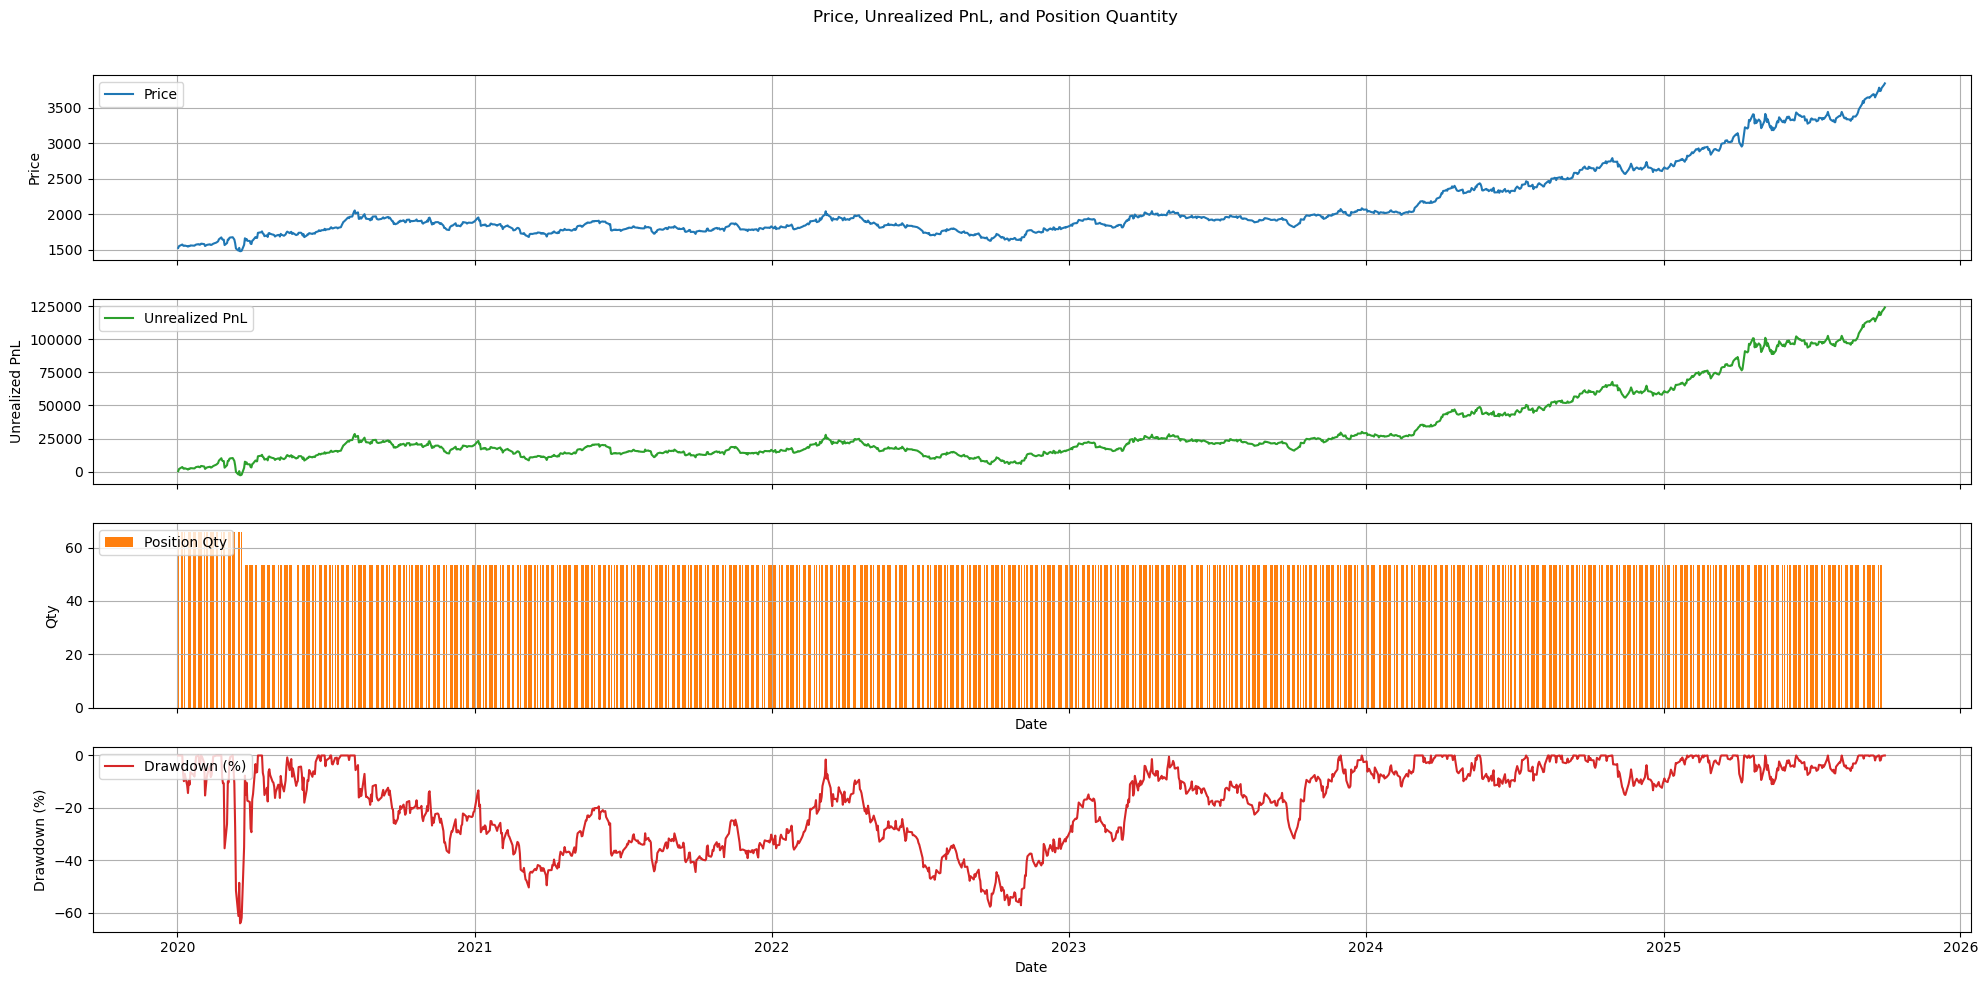

In [9]:
bt.plot_unrealized()

In [10]:
pd.DataFrame(bt.trades)

,date,price,qty,notional,fee_paid,reason
0,2020-01-02,1518.099976,65.871815,100000.000000,20.000000,init-buy
1,2020-03-23,1567.000000,-6.587181,10322.113334,2.064423,signal-sell
2,2020-03-24,1660.199951,-5.928463,9842.434491,1.968487,signal-sell
